##  3D reconstruction

To recreate our surrounding world in 3D from 2D images, the main thing we need is an actual depth map.

A depth map is a picture where every pixel has depth information (instead of color information).

It is normally represented like a grayscale picture where lighter shades of gray will signify objects close to the camera lens with progressively darker shades to distinguish objects further away.

The main steps needed to recreate your surrounding world in 3D are:

- Camera calibration
- Undistort images
- Feature matching
- Build point cloud
- Build mesh to get an actual 3D model

## Camera calibration

Camera calibration is the first, most important, easy task for 3D reconstruction.

I said easily because OpenCV provides a handful of functions that you can use to do that. You don't have to calculate the rotation and translation vectors by urself. OpenCV will do that for you.

### Different types of camera calibration

There are 4 major type of camera calibration process.
- Calibration pattern based
- Deep Learning based
- Geometric clue based

Among these methods **"Calibration pattern-based"** (checkerboard-based method, which I will use) method is the most popular. But to use this method you have to have complete control over the imaging process.

If you do not have control over your imaging process and also have a very small number of images (like only one image), you can use this **Deep Learning** method. Deep Learning is a very powerful tool to obtain certain information from an image.

Also, you may have some geometric clues like straight lines and vanishing points which can be used for calibrating the camera. This method is known as the **Geometric clue-based** method.

**Why checkerboard based method??**

- Checkerboard patterns are distinct and easy to detect in an image. 
- The corners of squares on the checkerboard are ideal for localizing them because they have sharp gradients in two directions
- Also, these corners are related by the fact that they are at the intersection of checkerboard lines.

#### Accure Images

The first step of camera calibration is to acquire images. As I am using the checkerboard-based method you can download a checkerboard image online, print it, and put it on a white wall. Then capture as many pictures as you need to calibrate the camera. 

Also, you can download the checkerboard images for camera calibration as I do. I use 41 images to calibrate the camera. You can use more.

#### Import librarys

In [1]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

First, define the dimensions of the checkerboard

In [24]:
CHECKERBOARD = (6,9)

If you take the images by yourself, you make take a picture of a portion of a checkerboard that is smaller or larger than my input images. Adjust this **CHECKERBOARD** size accordingly.

Now, define two array named **objpoints** and **imgpoints**

- Imgpoints **--** 2d points in image plane and
- Objpoints  **--** 3d point in real world space

In [3]:
# Creating vector to store vectors of 3D points for each checkerboard image
objpoints = []
# Creating vector to store vectors of 2D points for each checkerboard image
imgpoints = []
# Defining the world coordinates for 3D points
objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

#### Corner detection

Next, we will read all the images we take/downloaded for camera calibration and pass them to **findChessboardCorners()** function from OpenCV. This function will find all the corner points for us along with a boolean flag to indicate whether the function finds the corner points or not. The function takes grayscale images only, so you have to convert the input images to grayscale.

To make corner detection more robust we will use a sub-pixel level of accuracy. Again, for this sub-pixel level of accuracy calculation, you do not have to do anything new. OpenCV already have a function called **cornerSubPix()**. Achieving 100% accuracy in the sub-pixel level is difficult. So, you have to define a **criteria** that how long the function will look for the optimal solution. After meeting your desire criteria, the function will stop the iterative process of corner refinement.

In [4]:
# ( type, max_iter, epsilon )
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

There are option for criteria to stop the iteration.
- End condition
- max_iter
- epsilon/Accuracy

- End condition type: Has the following three flags:

- cv2.TERM_CRITERIA_EPS **--** Ends the iterative calculation when the specified accuracy ( epsilon ) is reached.
- cv2.TERM_CRITERIA_MAX_ITER **--** The iterative calculation ends when the specified number of repetitions ( max_iter ) is reached.
- cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER **--** The iterative calculation ends when either of the above conditions is met.

- max_iter **--** An integer value for specifying the maximum value for iterative calculation.

- epsilon **--** Required accuracy.

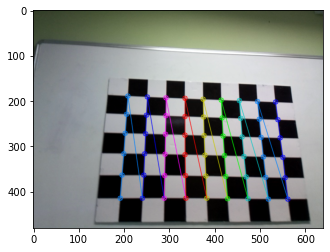

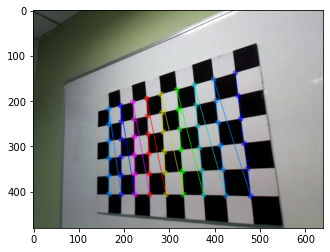

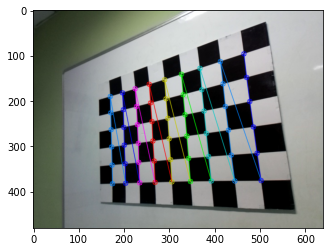

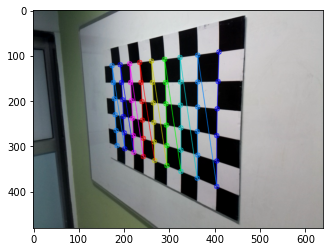

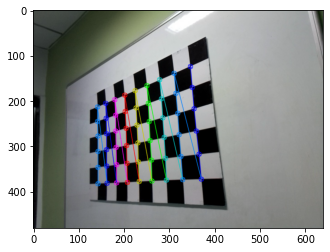

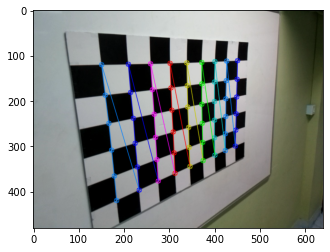

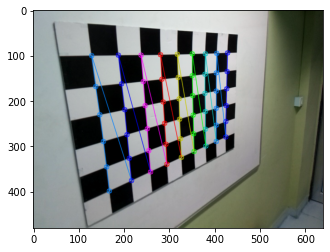

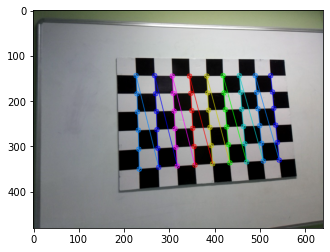

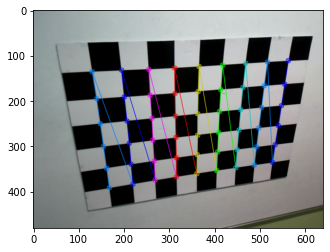

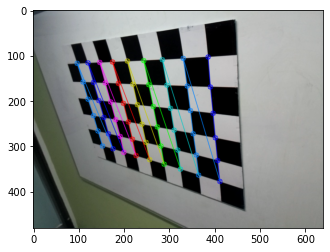

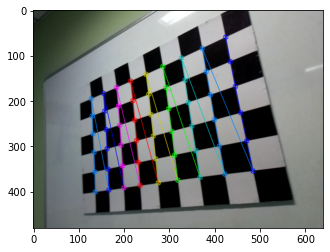

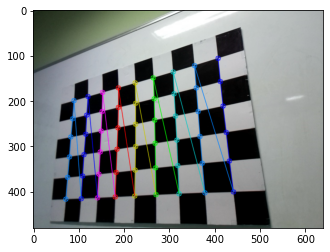

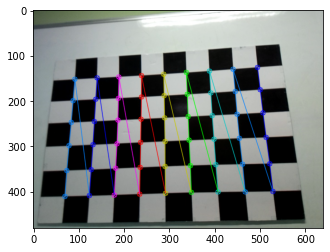

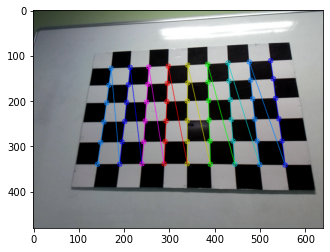

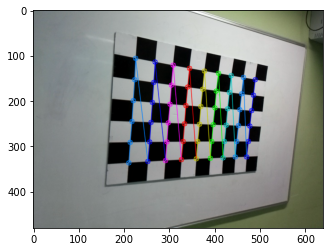

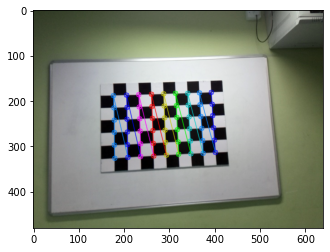

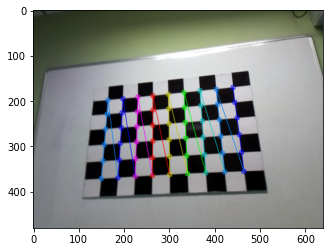

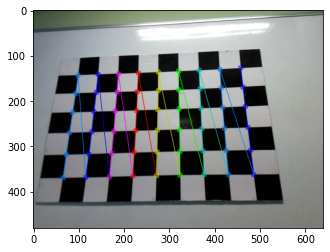

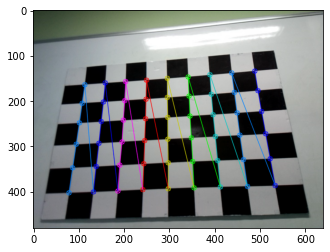

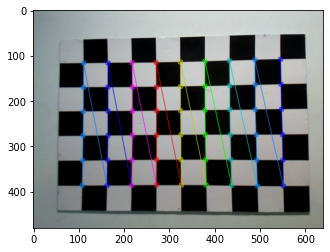

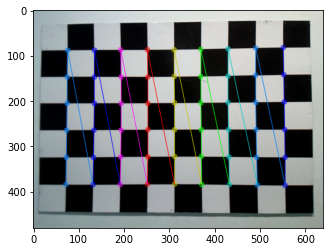

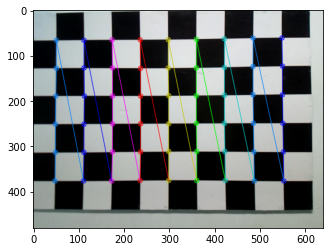

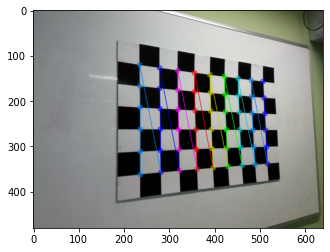

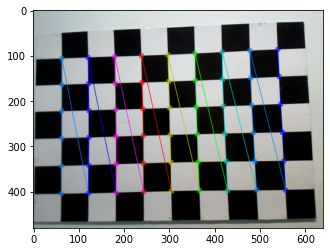

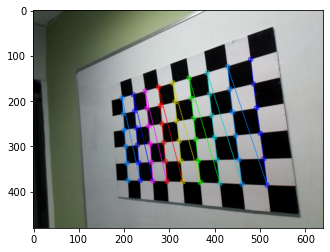

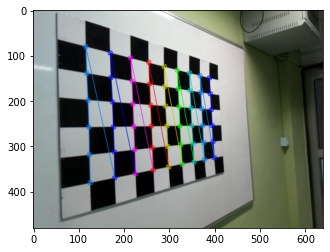

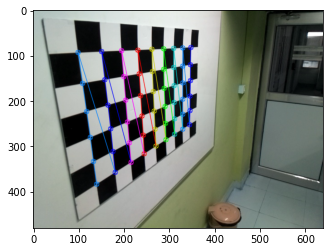

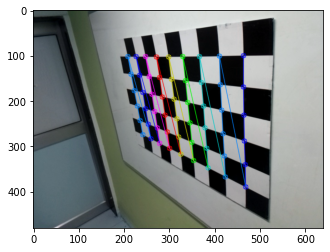

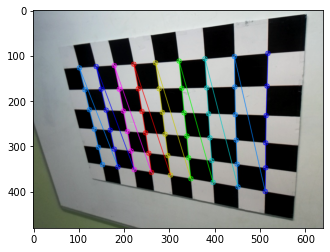

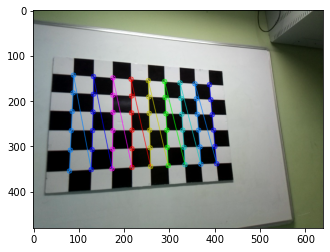

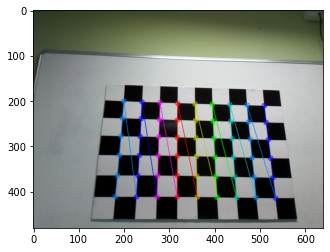

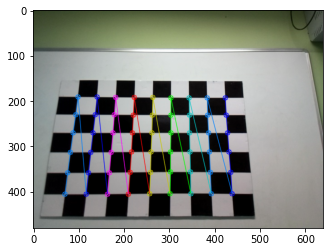

In [5]:
# Extracting path of individual image stored in a given directory
images = glob.glob('./images/*.jpg')
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    # If desired number of corners are found in the image then ret = true
    ret, corners = cv2.findChessboardCorners(gray,
                                             (6,9),
                                             cv2.CALIB_CB_ADAPTIVE_THRESH+
                                             cv2.CALIB_CB_FAST_CHECK+
                                             cv2.CALIB_CB_NORMALIZE_IMAGE)
    
    if ret == True:
        objpoints.append(objp)
        # refining pixel coordinates for given 2d points.
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners2,ret)
        plt.imshow(img)
        plt.show()

#### Calibrate Camera

Finally, we will pass the 3D points in world coordinates and their 2D locations in all images to OpenCV **calibrateCamera()** method.

In [6]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

This algorithm will output the camera parameters. The algorithm returns the camera matrix (mtx) distortion coefficients (dist) and the rotation and translation vectors (rvecs and tvecs).

In [7]:
print("Camera matrix : \n")
print(mtx)
print("dist : \n")
print(dist)
print("rvecs : \n")
print(rvecs)
print("tvecs : \n")
print(tvecs)

Camera matrix : 

[[503.68477278   0.         313.67563674]
 [  0.         503.37989194 243.25575476]
 [  0.           0.           1.        ]]
dist : 

[[ 2.08346324e-01 -4.68650266e-01  4.51079181e-04 -1.93373893e-03
   2.37592401e-01]]
rvecs : 

[array([[-0.31060359],
       [ 0.1515558 ],
       [ 1.57720394]]), array([[0.3139181 ],
       [0.58736866],
       [1.39910762]]), array([[0.33307297],
       [0.55841704],
       [1.39532836]]), array([[0.78743976],
       [0.53294469],
       [1.52233962]]), array([[0.42519317],
       [0.68127945],
       [1.34442524]]), array([[-0.40676505],
       [-0.72194813],
       [ 1.36334531]]), array([[-0.41607396],
       [-0.7647259 ],
       [ 1.33850247]]), array([[-0.23343341],
       [-0.04621596],
       [ 1.522275  ]]), array([[ 0.11068043],
       [-0.46502899],
       [ 1.48272651]]), array([[0.84715318],
       [0.19610195],
       [1.46485457]]), array([[0.28284572],
       [0.58780705],
       [1.3194868 ]]), array([[0.15172276]

You can save these camera parameters for further use.

In [8]:
#Save parameters into numpy file
np.save("./camera_params/ret", ret)
np.save("./camera_params/mtx", mtx)
np.save("./camera_params/dist", dist)
np.save("./camera_params/rvecs", rvecs)
np.save("./camera_params/tvecs", tvecs)

You can also calculate the projection errors as follows.

In [9]:
#Calculate projection error. 
mean_error = 0
for i in range(len(objpoints)):
	img_points2, _ = cv2.projectPoints(objpoints[i],rvecs[i],tvecs[i], mtx, dist)
	error = cv2.norm(imgpoints[i], img_points2, cv2.NORM_L2)/len(img_points2)
	mean_error += error

total_error = mean_error/len(objpoints)
print (total_error)

0.03108792528908075


### Stereo 3D reconstruction 

Now our camera is calibrated with a low error. Next, we will try to reconstruct a 3D image from 2 2D images.

In [12]:
#Load pictures
img_1 = cv2.imread('./reconstruct_this/st_left.png')
img_2 = cv2.imread('./reconstruct_this/st_right.png')

**For this reconstruction process both images shape must be same. For me both image is already in the same size.**

In [13]:
img_1.shape, img_2.shape

((480, 640, 3), (480, 640, 3))

If your input images are not same sized please resize them to same size.

In [14]:
h,w = img_2.shape[:2]

#### Undistortion

Next, we have to undistortion the input images. For better undistortion we can use OpenCV's **getOptimalNewCameraMatrix()**. This function will use our existing camera matrix, distortion coefficients and refine them for new images.

In [15]:
new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

In [16]:
#Undistort images
img_1_undistorted = cv2.undistort(img_1, mtx, dist, None, new_camera_matrix)
img_2_undistorted = cv2.undistort(img_2, mtx, dist, None, new_camera_matrix)

#### Compute disparity  map/depth map

Next will compute the disparity map for the undistorted images. First I set disparity parameters. These parameters are arbitrarily chosen. You can improve the final output by tuning these parameters.

In [17]:
#Set disparity parameters 
win_size = 5
min_disp = -1
max_disp = 63 #min_disp * 9
num_disp = max_disp - min_disp # Needs to be divisible by 16

Then we create a Semi-Global Block Matching algorithm from OpenCV called **"StereoSGBM_create()"**. This function will generate a depth map for our input images.


Computing the disparity  map...


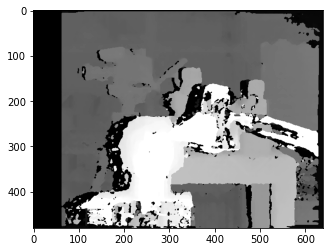

In [18]:
#Create Block matching object. 
stereo = cv2.StereoSGBM_create(minDisparity= min_disp,
	numDisparities = num_disp,
	blockSize = 5,
	uniquenessRatio = 5,
	speckleWindowSize = 5,
	speckleRange = 5,
	disp12MaxDiff = 2,
	P1 = 8*3*win_size**2,
	P2 =32*3*win_size**2)

#Compute disparity map
print ("\nComputing the disparity  map...")
disparity_map = stereo.compute(img_1_undistorted, img_2_undistorted)

#Show disparity map before generating 3D cloud to verify that point cloud will be usable. 
plt.imshow(disparity_map,'gray')
plt.show()

In the beginning, we said that lighter shades of gray will signify objects close to the camera lens with progressively darker shades to distinguish objects further away.

We can plot all three images side by side (two input images and one generated gray-scale depth map image) and verify our statement.

#### Compare output

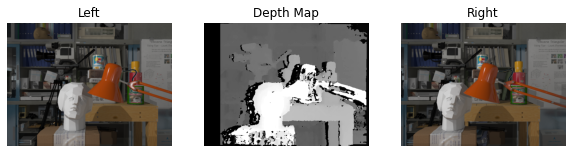

In [19]:
fig = plt.figure(figsize=(10, 7))

# showing left image
fig.add_subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.title("Left")

# showing depth mapimage
fig.add_subplot(1, 3, 2)
plt.imshow(disparity_map, cmap='gray')
plt.axis('off')
plt.title("Depth Map")

# showing right image
fig.add_subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(img_2, cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.title("Right")
plt.show()

The output is not perfect but we can see that the objects which are comparatively close to the camera are marked as lite-gray (white) and objects that are far from the camera are marked as dark-gray (black).

In [20]:
def create_output(vertices, colors, filename):
	colors = colors.reshape(-1,3)
	vertices = np.hstack([vertices.reshape(-1,3),colors])

	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar red
		property uchar green
		property uchar blue
		end_header
		'''
	with open(filename, 'w') as f:
		f.write(ply_header %dict(vert_num=len(vertices)))
		np.savetxt(f,vertices,'%f %f %f %d %d %d')


### Visulize output

We can visualize the output by generating a point cloud. Meshlab is a great tool to visualize the reconstructed images.

#### Build point cloud

To create a point cloud, we need the focal length of the camera we use to take the images. Focal length can be described from Exif data contained in the picture.

<pre>
exif_img = PIL.Image.open('./reconstruct_this/st_left.png')
exif_data = {
 PIL.ExifTags.TAGS[k]:v
 for k, v in exif_img._getexif().items()
 if k in PIL.ExifTags.TAGS}
#Get focal length in tuple form
focal_length_exif = exif_data['FocalLength']
#Get focal length in decimal form
focal_length = focal_length_exif[0]/focal_length_exif[1]
</pre>

In [21]:
#Generate  point cloud. 
print ("\nGenerating the 3D map...")
#Get width and height 
h,w = img_2_undistorted.shape[:2]
#Load focal length. 
focal_length = np.load('./camera_params/FocalLength.npy')
#Perspective transformation matrix
#This transformation matrix is from the openCV documentation, didn't seem to work for me. 
Q = np.float32([[1,0,0,-w/2.0],
    [0,-1,0,h/2.0],
    [0,0,0,-focal_length],
    [0,0,1,0]])
#This transformation matrix is derived from Prof. Didier Stricker's power point presentation on computer vision. 
#Link : https://ags.cs.uni-kl.de/fileadmin/inf_ags/3dcv-ws14-15/3DCV_lec01_camera.pdf
Q2 = np.float32([[1,0,0,0],
    [0,-1,0,0],
    [0,0,focal_length*0.05,0], #Focal length multiplication obtained experimentally. 
    [0,0,0,1]])
#Reproject points into 3D
points_3D = cv2.reprojectImageTo3D(disparity_map, Q2)
#Get color points
colors = cv2.cvtColor(img_1_undistorted, cv2.COLOR_BGR2RGB)
#Get rid of points with value 0 (i.e no depth)
mask_map = disparity_map > disparity_map.min()
#Mask colors and points. 
output_points = points_3D[mask_map]
output_colors = colors[mask_map]
#Define name for output file
output_file = 'output/reconstructed.ply'
#Generate point cloud 
print ("\nCreating the output file... \n")
create_output(output_points, output_colors, output_file)


Generating the 3D map...

Creating the output file... 



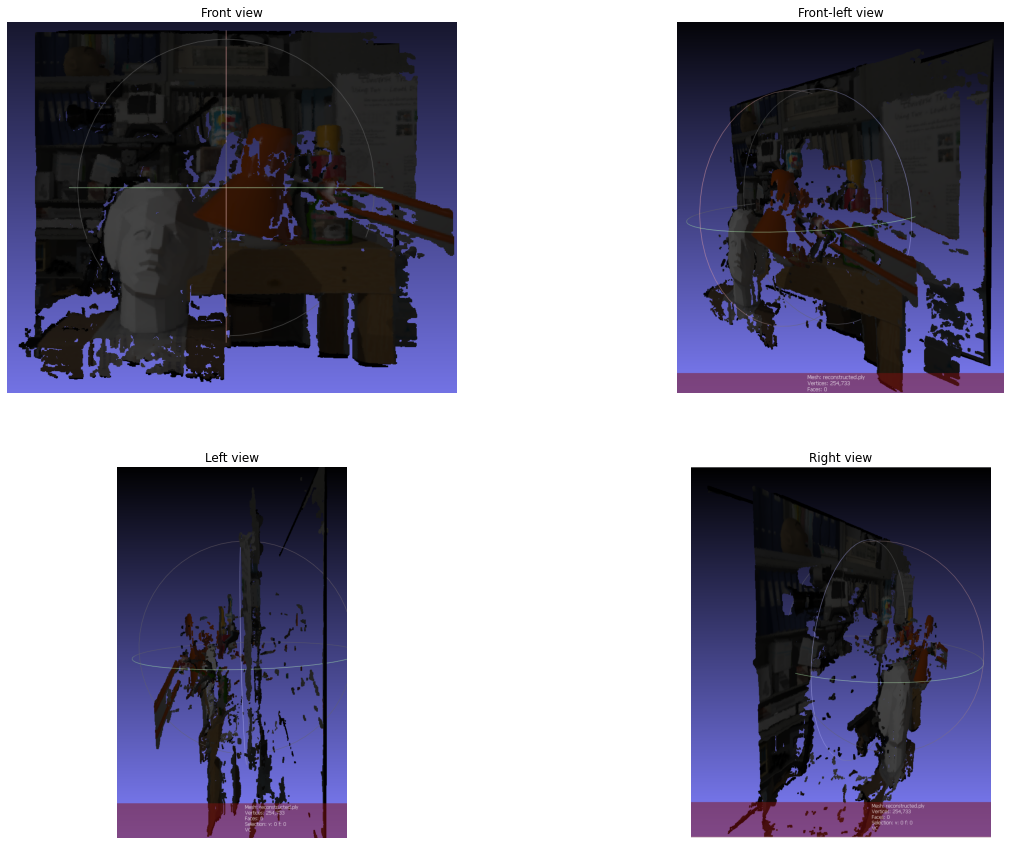

In [22]:
# create figure
fig = plt.figure(figsize=(20, 15))
  
# setting values to rows and column variables
rows = 2
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(cv2.cvtColor(cv2.imread('./output/front.png'), cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.title("Front view")
  
fig.add_subplot(rows, columns, 2)
plt.imshow(cv2.cvtColor(cv2.imread('./output/front-left.png'), cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.title("Front-left view")

fig.add_subplot(rows, columns, 3)
plt.imshow(cv2.cvtColor(cv2.imread('./output/left.png'), cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.title("Left view")

fig.add_subplot(rows, columns, 4)
plt.imshow(cv2.cvtColor(cv2.imread('./output/right.png'), cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.title("Right view")
plt.show()

### Resourses

I did not described the theory behind the process. If you are interested about the theory, you can read the additional resourse files.

<a href="https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_calib3d/py_calibration/py_calibration.html#calibration">Camera Calibration</a>

<a href="https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_calib3d/py_epipolar_geometry/py_epipolar_geometry.html#epipolar-geometry">Epipolar Geometry</a>

<a href="https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_calib3d/py_depthmap/py_depthmap.html#py-depthmap">Depth Map from Stereo Images</a>